# Gradient Boosting with Hyperparamter optimization

In this notebook, we now use a different model: GradientBoostingRegressor.

The GradientBoostingRegressor uses Gradient Boosting with Decision Trees to learn (fit) the data.

We didn't have a look at Gradient Boosting in the course.
For those that are interested, in this playlist (https://www.youtube.com/watch?v=Un9zObFjBH0&list=PLAwxTw4SYaPnIRwl6rad_mYwEk4Gmj7Mx&index=191) video 191 till 194 make a good introduction to Boosting.
If you understand Boosting, Gradient Boosting is easy to understand: We simply make a Boosting Ensemble with Decision Trees.

From the previous code not many changes, we simply replace the LinearRegression model with the GradientBoostingRegressor model, when defining the pipeline.

However, GradientBoostingRegressor has now hyper-parameters.
Therefore, to improve our model, we use Hyperparameter Optimization with Cross-Validation to find good hyper-parameters.

In this notebook, we show how to use Grid Search as well as Random Search to do Hyperparameter Optimization

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

# Prepare data

In [2]:
# Load the train data
train_data = pd.read_csv('../data/houses_train.csv', index_col=0)

In [3]:
# Split data into features and labels.
X_data = train_data.drop(columns='price')
y_data = train_data['price']

In [4]:
# Split features and labels into train (X_train, y_train) and validation set (X_val, y_val).
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, stratify=X_data['object_type_name'], test_size=0.1)

## Helper functions

In [5]:
def evaluate_model(model, X, y):
    # Predict with the model the validation data.
    y_pred = model.predict(X)

    # How good are we on the validation data?
    print(mean_absolute_percentage_error(y, y_pred))

# Define and train models

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

## Descision Tree

In [9]:
# Define model
model = Pipeline([
    ('ohe', 
        make_column_transformer(
            (OneHotEncoder(handle_unknown='ignore'), ['zipcode', 'municipality_name', 'object_type_name']),
            remainder='passthrough'
        )
    ),
    ('reg', 
        TransformedTargetRegressor(
            regressor=DecisionTreeRegressor(),
            func=np.log,
            inverse_func=np.exp
        )
    )
])

# Train (fit) the model with the train data.
model.fit(X_train, y_train)

# Evaluate
evaluate_model(model, X_val, y_val)

0.2828091003132036


## Gradient Boosting

In [10]:
# Define model
model = Pipeline([
    ('ohe', 
        make_column_transformer(
            (OneHotEncoder(handle_unknown='ignore'), ['zipcode', 'municipality_name', 'object_type_name']), 
            remainder='passthrough'
        )
    ),
    ('reg', 
        TransformedTargetRegressor(
            regressor=GradientBoostingRegressor(
                n_estimators=100,
                max_depth = 3
            ),
            func=np.log,
            inverse_func=np.exp
        )
    )
])

# Train (fit) the model with the train data.
_ = model.fit(X_train, y_train)

# Evaluate
evaluate_model(model, X_val, y_val)

0.22106681030984307


# Grid search

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
# We have 4 * 3 parameter combinations with 5 cross validation runs per configurations.
# Therefore we fit 60 models here in total (actually 61 because of refit).
parameters = {
    'reg__regressor__n_estimators': [10,50,100,200],
    'reg__regressor__max_depth': [2,3,5],
}
grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'reg__regressor__max_depth': 5, 'reg__regressor__n_estimators': 200}

In [11]:
grid_search.cv_results_

{'mean_fit_time': array([ 0.60599837,  2.55653701,  5.31037316, 10.71305695,  0.91821375,
         4.45160108,  8.47721982, 16.13624763,  1.94285002,  8.43197656,
        13.65416746, 18.61539564]),
 'std_fit_time': array([0.00717861, 0.01317339, 0.02511045, 0.06565182, 0.05154995,
        0.03700024, 0.03514174, 0.10142644, 0.00659944, 0.0477022 ,
        0.0655618 , 1.10464703]),
 'mean_score_time': array([0.0289072 , 0.03050776, 0.03994379, 0.05246062, 0.03988824,
        0.03387828, 0.04373622, 0.06054621, 0.03494601, 0.04344134,
        0.03653507, 0.04336939]),
 'std_score_time': array([0.00248699, 0.00050976, 0.00387498, 0.00295843, 0.01305781,
        0.00076408, 0.00041892, 0.00172714, 0.00520523, 0.00240346,
        0.00510011, 0.00195534]),
 'param_reg__regressor__max_depth': masked_array(data=[2, 2, 2, 2, 3, 3, 3, 3, 5, 5, 5, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?

In [12]:
# Evaluate
evaluate_model(grid_search, X_val, y_val)

0.2027073330795121


# Random search

Because the number of models to fit explodes in grid search quit fast, in practice often Random Search is used.

In [13]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'reg__regressor__n_estimators': range(10,200),
    'reg__regressor__max_depth': range(2,10),
}
random_search = RandomizedSearchCV(model, parameters, cv=5, n_jobs=-1, n_iter=25, scoring='neg_mean_absolute_percentage_error')
random_search.fit(X_train, y_train)
random_search.best_params_

{'reg__regressor__n_estimators': 187, 'reg__regressor__max_depth': 9}

In [14]:
# We take the model fitted with the hyper parameters found by Random Search here.
final_model = random_search.best_estimator_

In [15]:
# Evaluate
evaluate_model(final_model, X_val, y_val)

0.192885737526685


## Feature Importance

In [16]:
feature_importance = pd.DataFrame(final_model['ohe'].get_feature_names_out(), columns=['feature'])
feature_importance['importance'] = final_model['reg'].regressor_.feature_importances_

In [17]:
feature_importance.sort_values('importance', ascending=False).head(20)

,feature,importance
4329,remainder__living_area,0.487604
4333,remainder__travel_time_public_transport,0.102042
4327,remainder__long,0.077454
4328,remainder__build_year,0.067777
4326,remainder__lat,0.057900
4332,remainder__travel_time_private_transport,0.029943
4331,remainder__water_percentage_1000,0.027359
4330,remainder__num_rooms,0.014595
416,onehotencoder__zipcode_1936,0.013567
4340,remainder__population_in_hectare,0.009884


## Learning Curve

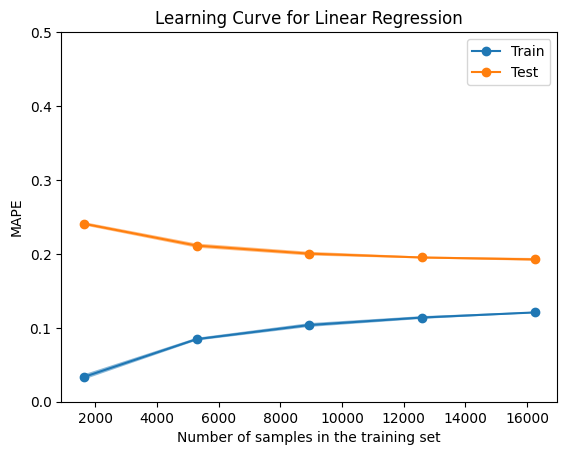

In [18]:
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

common_params = {
    "X": X_data,
    "y": y_data,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=42),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "MAPE",
}
lcd = LearningCurveDisplay.from_estimator(final_model, **common_params, scoring='neg_mean_absolute_percentage_error', negate_score=True)
lcd.ax_.set_ylim(ymin=0.00, ymax=0.5)
plt.title("Learning Curve for Linear Regression")
plt.show()